# 2023-04-14 Quadrature

## Last time

* Midpoint and trapezoid rules
* Extrapolation

## Today

* Polynomial interpolation for integration
* Gauss quadrature

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

F_expx(x) = exp(2x) / (1 + x^2)
f_expx(x) = 2*exp(2x) / (1 + x^2) - 2x*exp(2x)/(1 + x^2)^2

F_dtanh(x) = tanh(x)
f_dtanh(x) = cosh(x)^-2

integrands = [f_expx, f_dtanh]
antiderivatives = [F_expx, F_dtanh]
tests = zip(integrands, antiderivatives)

function plot_accuracy(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="n", ylabel="error")
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(ns, Errors, label=f)
    end
    for k in ref
        plot!(ns, ns.^(-1. * k), label="\$n^{-$k}\$")
    end
    p
end

function fint_trapezoid(f, a, b; n=20)
    dx = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    fx = f.(x)
    fx[1] /= 2
    fx[end] /= 2
    sum(fx) * dx
end

function plot_accuracy_h(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="h", ylabel="error",
        legend=:bottomright)
    hs = (b - a) ./ ns
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(hs, Errors, label=f)
    end
    for k in ref
        plot!(hs, hs.^k, label="\$h^{$k}\$")
    end
    p
end

plot_accuracy_h (generic function with 1 method)

# Integration

We're interested in computing definite integrals

$$ \int_a^b f(x) dx $$

and will usually consider finite domains $-\infty < a <b < \infty$.

* Cost: (usually) how many times we need to evaluate the function $f(x)$
* Accuracy
  * compare to a reference value
  * compare to the same method using more evaluations
* Consideration: how smooth is $f$?

## Extrapolation

Let's switch our plot around to use $h = \Delta x$ instead of number of points $n$.

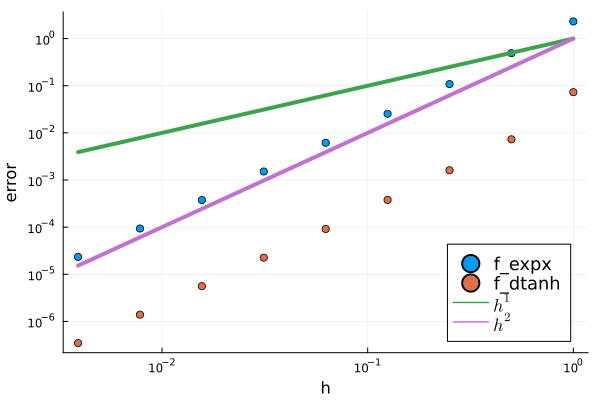

In [2]:
plot_accuracy_h(fint_trapezoid, tests, 2 .^ (2:10))

# Extrapolation math
The trapezoid rule with $n$ points has an interval spacing of $h = 1/(n-1)$.  Let $I_h$ be the value of the integral approximated using an interval $h$.  We have numerical evidence that the leading error term is $O(h^2)$, i.e.,
$$ I_h - I_0 = c h^2 + O(h^3) $$
for some as-yet unknown constant $c$ that will depend on the function being integrated and the domain of integration.
If we can determine $c$ from two approximations, say $I_h$ and $I_{2h}$, then we can extrapolate to $h=0$.
For sufficiently small $h$, we can neglect $O(h^3)$ and write
$$\begin{split} I_h - I_0 &= c h^2 \\
I_{2h} - I_0 &= c (2h)^2 .
\end{split}$$
Subtracting these two lines, we have
$$ I_{h} - I_{2h} = c (h^2 - 4 h^2) $$
which can be solved for $c$ as
$$ c = \frac{I_{h} - I_{2h}}{h^2 - 4 h^2} . $$
Substituting back into the first equation, we solve for $I_0$ as
$$ I_0 = I_h - c h^2 = I_h + \frac{I_{h} - I_{2h}}{4 - 1} .$$
This is called **Richardson extrapolation**.

# Extrapolation code

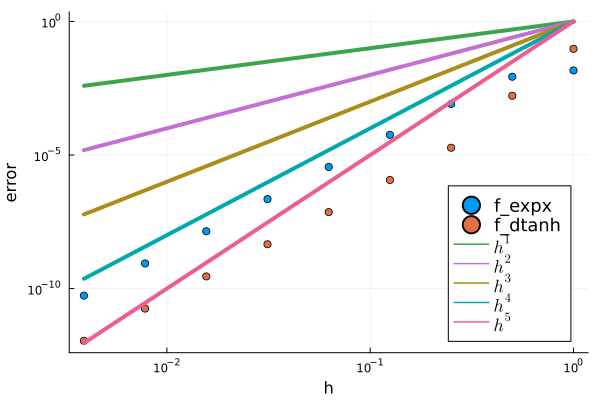

In [3]:
function fint_richardson(f, a, b; n=20)
    n = div(n, 2) * 2 + 1
    h = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    fx = f.(x)
    fx[[1, end]] /= 2
    I_h = sum(fx) * h
    I_2h = sum(fx[1:2:end]) * 2h
    I_h + (I_h - I_2h) / 3
end
plot_accuracy_h(fint_richardson, tests, 2 .^ (2:10), ref=1:5)

* we now have a sequence of accurate approximations
* it's possible to apply extrapolation recursively
* works great if you have a power of 2 number of points
  * and your function is nice enough

# Quadrature form

At the end of the day, we're taking a weighted sum of function values. We call $w_i$ the *quadrature weights* and $x_i$ the *quadrature points* or *abscissa*.

$$\int_a^b f(x) \approx \sum_{i=1}^n w_i f(x_i) = \mathbf w^T f(\mathbf x)$$

In [4]:
function quad_trapezoid(a, b; n=20)
    dx = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    w = fill(dx, n)
    w[[1, end]] /= 2
    x, w
end

quad_trapezoid (generic function with 1 method)

In [14]:
x, w = quad_trapezoid(-1, 1)

w' * cos.(x) - fint_trapezoid(cos, -1, 1)

2.220446049250313e-16

# Polynomial interpolation for integration

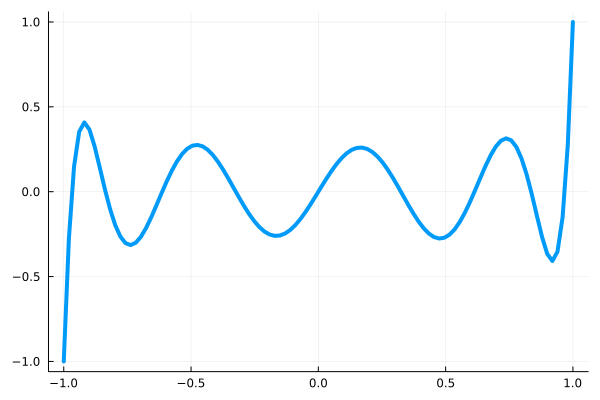

In [22]:
x = LinRange(-1, 1, 100)
P = vander_legendre(x, 10)
plot(x, P[:,end], legend=:none)

## Idea

* Sample the function $f(x)$ at some points $x \in [-1, 1]$
* Fit a polynomial through those points
* Return the integral of that interpolating polynomial

## Question

* What points do we sample on?
* How do we integrate the interpolating polynomial?

Recall that the Legendre polynomials $P_0(x) = 1$, $P_1(x) = x$, ..., are pairwise orthogonal

$$\int_{-1}^1 P_m(x) P_n(x) = 0, \quad \forall m\ne n.$$

# Integration using Legendre polynomials

In [15]:
function quad_legendre(a, b; n=20)
    x = CosRange(-1, 1, n)
    P = vander_legendre(x)
    x_ab = (a+b)/2 .+ (b-a)/2*x
    w = (b - a) * inv(P)[1,:]
    x_ab, w
end

function fint_legendre(f, a, b; n=20)
    x, w = quad_legendre(a, b, n=n)
    w' * f.(x)
end

fint_legendre(x -> 1 + x, -1, 1, n=4)

2.0

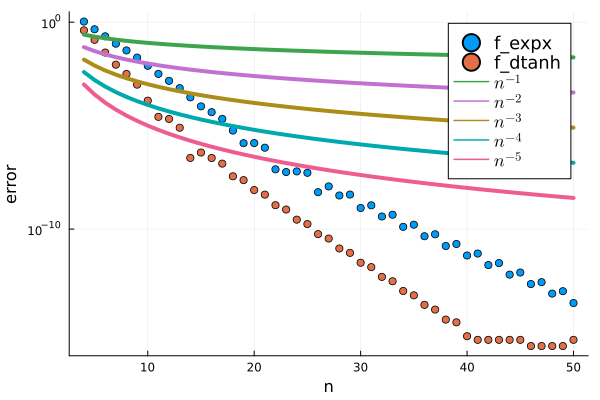

In [17]:
p = plot_accuracy(fint_legendre, tests, 4:50, ref=1:5)
plot!(p, xscale=:linear)

# Doing better
Suppose a polynomial on the interval $[-1,1]$ can be written as

$$ P_n(x) q(x) + r(x) $$

where $P_n(x)$ is the $n$th Legendre polnomials and both $q(x)$ and $r(x)$ are polynomials of maximum degree $n-1$.

* Why is $\int_{-1}^1 P_n(x) q(x) = 0$?
* Can every polynomials of degree $2n-1$ be written in the above form?
* How many roots does $P_n(x)$ have on the interval?
* Can we choose points $\{x_i\}$ such that the first term is 0?

If $P_n(x_i) = 0$ for each $x_i$, then we need only integrate $r(x)$, which is done exactly by integrating its interpolating polynomial.  How do we find these roots $x_i$?

# Gauss-Legendre in code

1. Solve for the points, compute the weights
  * Use a Newton solver to find the roots. You can use the recurrence to write a recurrence for the derivatives.
  * Create a Vandermonde matrix and extract the first row of the inverse or (using more structure) the derivatives at the quadrature points.
2. Use duality of polynomial roots and matrix eigenvalues.
  * A fascinating mathematical voyage; something you might see more in a graduate linear algebra class.

In [27]:
function fint_gauss(f, a, b; n=4)
    """Gauss-Legendre integration using Golub-Welsch algorithm"""
    beta = @. .5 / sqrt(1 - (2 * (1:n-1))^(-2))
    T = diagm(-1 => beta, 1 => beta)
    D, V = eigen(T)
    w = V[1,:].^2 * (b-a)
    x = (a+b)/2 .+ (b-a)/2 * D
    w' * f.(x)
end
fint_gauss(sin, -2, 3, n=4)

0.5733948071694299

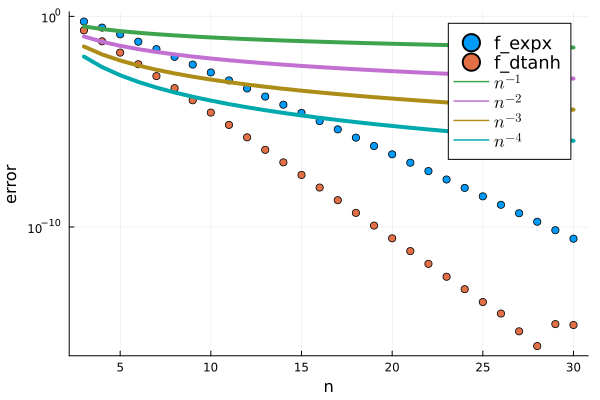

In [28]:
plot_accuracy(fint_gauss, tests, 3:30, ref=1:4)
plot!(xscale=:linear)

## $n$-point Gauss exactly integrates polynomials of degree $2n-1$

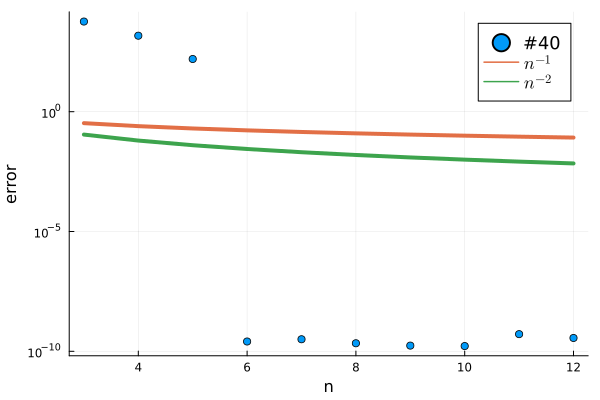

In [31]:
plot_accuracy(fint_gauss, [(x -> 12(x-.2)^11, x->(x-.2)^12)], 3:12)
plot!(xscale=:linear)

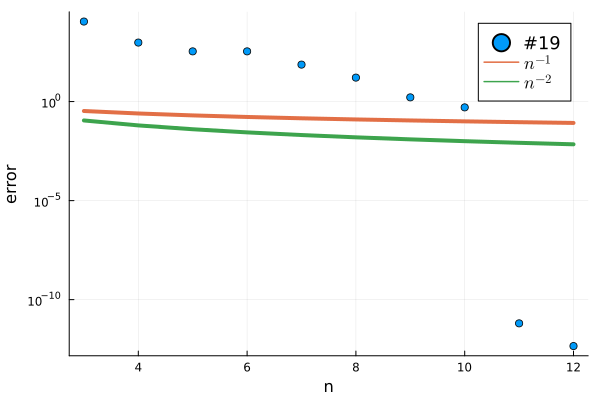

In [12]:
plot_accuracy(fint_legendre, [(x -> 11x^10, x->x^11)], 3:12)
plot!(xscale=:linear)

# [FastGaussQuadrature.jl](https://juliaapproximation.github.io/FastGaussQuadrature.jl/stable/)


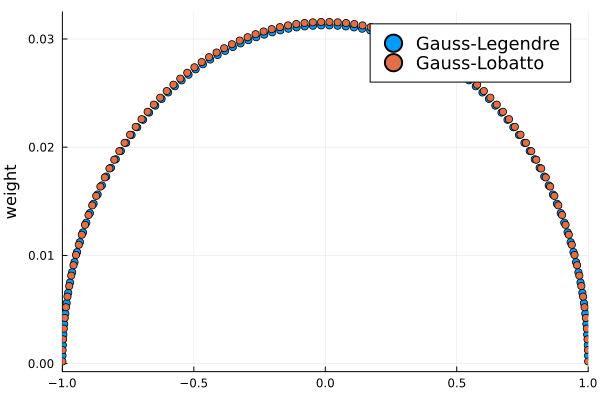

In [33]:
using FastGaussQuadrature

n = 100
x, q = gausslegendre(n)
scatter(x, q, label="Gauss-Legendre", ylabel="weight", xlims=(-1, 1))
scatter!(gausslobatto(n)..., label="Gauss-Lobatto")